#### GAMLSS modelling of tree taper

In [1]:
library(mgcv)
library(dplyr)
library(ggplot2)
library(Metrics)
library(gratia)
library(rsample)
library(parallel)
library(gamlss)
library(gamlss.add)
library(ggpubr)
library(ggplot2)
library(car)

Loading required package: nlme

This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.


Attaching package: ‘dplyr’


The following object is masked from ‘package:nlme’:

    collapse


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: splines

Loading required package: gamlss.data


Attaching package: ‘gamlss.data’


The following object is masked from ‘package:datasets’:

    sleep


Loading required package: gamlss.dist

 **********   GAMLSS Version 5.5-0  ********** 

For more on GAMLSS look at https://www.gamlss.com/

Type gamlssNews() to see new features/changes/bug fixes.



Attaching package: ‘gamlss’


The following object is masked from ‘package:rsample’:

    calibration


The following object is masked from ‘package:gratia’:

    edf


Loading required package: nnet


Attaching package: ‘nnet’


The following object is mas

In [2]:
theme_consistent <- function(){
  theme_bw()+
    theme(text = element_text(size=10),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          strip.background = element_blank(),
          axis.text.x = element_text(color="black"),
          axis.text.y = element_text(color="black"),
          axis.ticks = element_line(color = "black",linewidth=0.2),
          panel.border = element_rect(color = "black", fill = NA)
    ) 
}

In [3]:
options(mc.cores = parallel::detectCores())

In [5]:
dados <- read.csv('test.csv')

In [6]:
dados$id <- seq(1,length(dados$d),by=1)
dados$loghih <- log(dados$hih+1)
volumes <- aggregate(dados$vi,by=list(dados$ID),FUN=sum)
diameters <- aggregate(dados$d,by=list(dados$ID),FUN=mean)
heights <- aggregate(dados$h,by=list(dados$ID),FUN=mean)


In [7]:
total_vols <- cbind(v=volumes,d =diameters,h =heights)

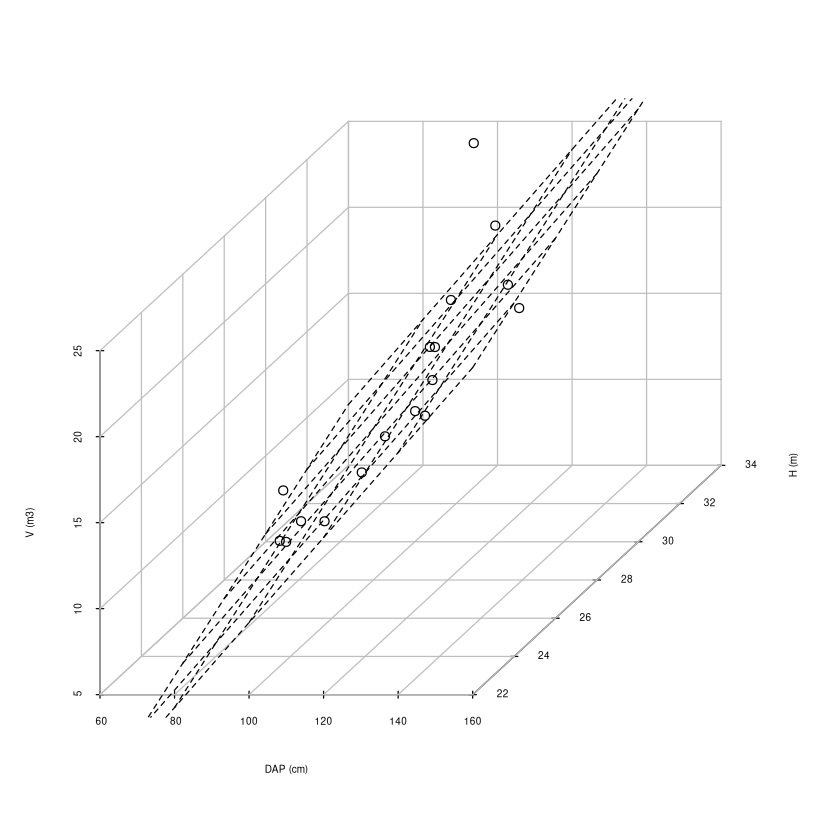

In [10]:
library(scatterplot3d)
source('https://www.sthda.com/sthda/RDoc/functions/addgrids3d.r')
s3d <-scatterplot3d(total_vols$d.x, 
              total_vols$h.x, 
              total_vols$v.x, 
              xlab = "DAP (cm)", 
              ylab = "H (m)", 
              zlab = "V (m3)",
              pch = "",        
              color = "black",
              grid = FALSE, 
              box = FALSE,
              cex.axis=0.5,
              cex.lab = 0.5)
addgrids3d(total_vols$d.x, 
           total_vols$h.x, 
           total_vols$v.x, grid = c("xy", "xz", "yz"))
s3d$points3d(total_vols$d.x, 
             total_vols$h.x, 
             total_vols$v.x, pch = 1)
lm <- lm(total_vols$v.x ~ total_vols$d.x + total_vols$h.x)
s3d$plane3d(lm)# regressao linear simples para demonstrar crescimento na variavel V*


In [11]:
set.seed(412)
train_ratio <- 0.9
ID_arvores <- unique(dados$ID)
train_treeIDs<- sample(ID_arvores, size = round(train_ratio * length(ID_arvores))) #estratificar para manter mesmos IDS
train <- subset(dados, ID %in% train_treeIDs)
test <- subset(dados, !ID %in% train_treeIDs)
train$ID <- as.factor(train$ID)
test$ID <- as.factor(test$ID)

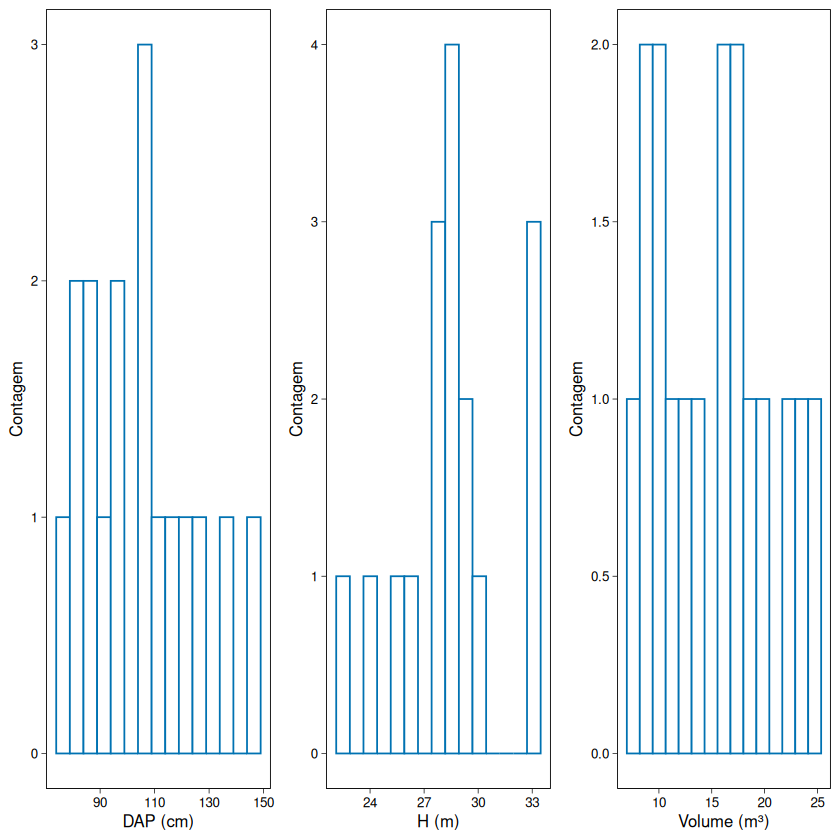

In [12]:
k <- 1 + 3.3 * log2(length(dados))
hist_d <- ggplot(aes(x=d.x),data=total_vols) + geom_histogram(colour = "#0072B2", fill = "white", 
                                             bins = round(k,0)) +
  labs(x='DAP (cm)', y='Contagem') + theme_consistent()

hist_h <- ggplot(aes(x=h.x),data=total_vols) + geom_histogram(colour = "#0072B2", fill = "white", 
                                             bins =  round(k,0)) +
  labs(x='H (m)', y='Contagem') + theme_consistent()
hist_v <- ggplot(aes(x=v.x),data=total_vols) + geom_histogram(colour = "#0072B2", fill = "white", 
                                                              bins =  round(k,0)) +
  labs(x='Volume (m³)', y='Contagem') + theme_consistent()

ggarrange(hist_d,hist_h,hist_v,ncol = 3)

In [14]:
library(e1071)
skewness(total_vols$d.x)
skewness(total_vols$h.x)
skewness(total_vols$v.x)

kurtosis(total_vols$d.x)
kurtosis(total_vols$h.x)
kurtosis(total_vols$v.x)


Attaching package: ‘e1071’


The following object is masked from ‘package:rsample’:

    permutations


The following object is masked from ‘package:ggplot2’:

    element




[1] 0.4860679

[1] -0.1138974

[1] 0.164099

[1] -0.8176657

[1] -0.4612459

[1] -1.377975

In [15]:
lm2 <- gamlss(di ~ d + h + log(hih + 1),
              sigma.formula = ~  hi + h,
              nu.formula = ~  d+ log(hih+1),
              tau.formula = ~ log(hih+1) + h,
              data=train,family=BCT)

GAMLSS-RS iteration 1: Global Deviance = 548.0969 
GAMLSS-RS iteration 2: Global Deviance = 547.4365 
GAMLSS-RS iteration 3: Global Deviance = 547.3975 
GAMLSS-RS iteration 4: Global Deviance = 547.3906 
GAMLSS-RS iteration 5: Global Deviance = 547.3892 
GAMLSS-RS iteration 6: Global Deviance = 547.3887 


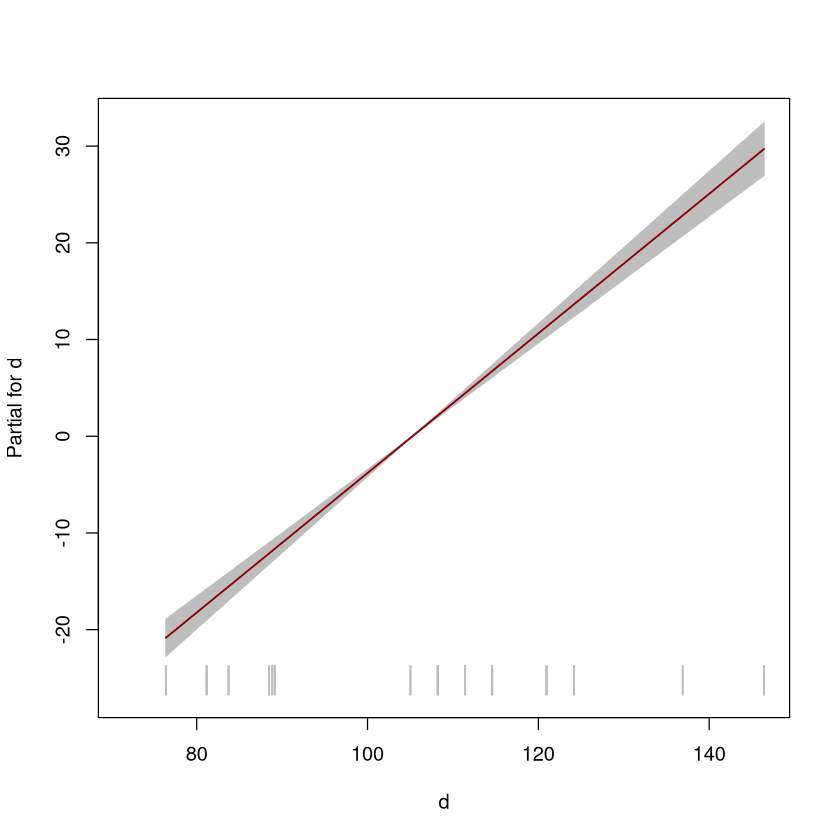

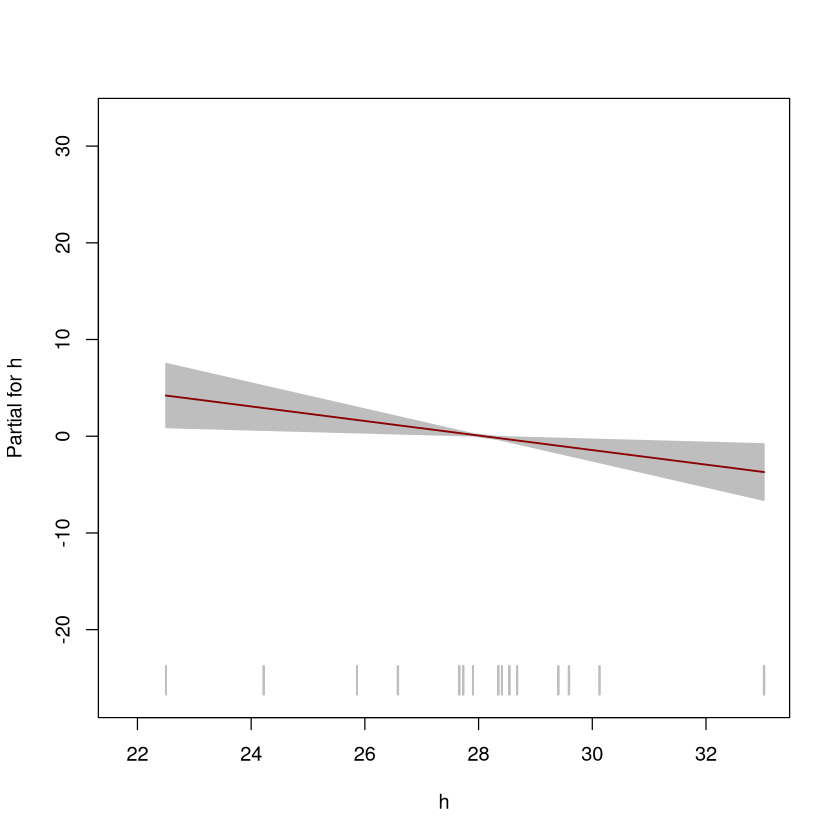

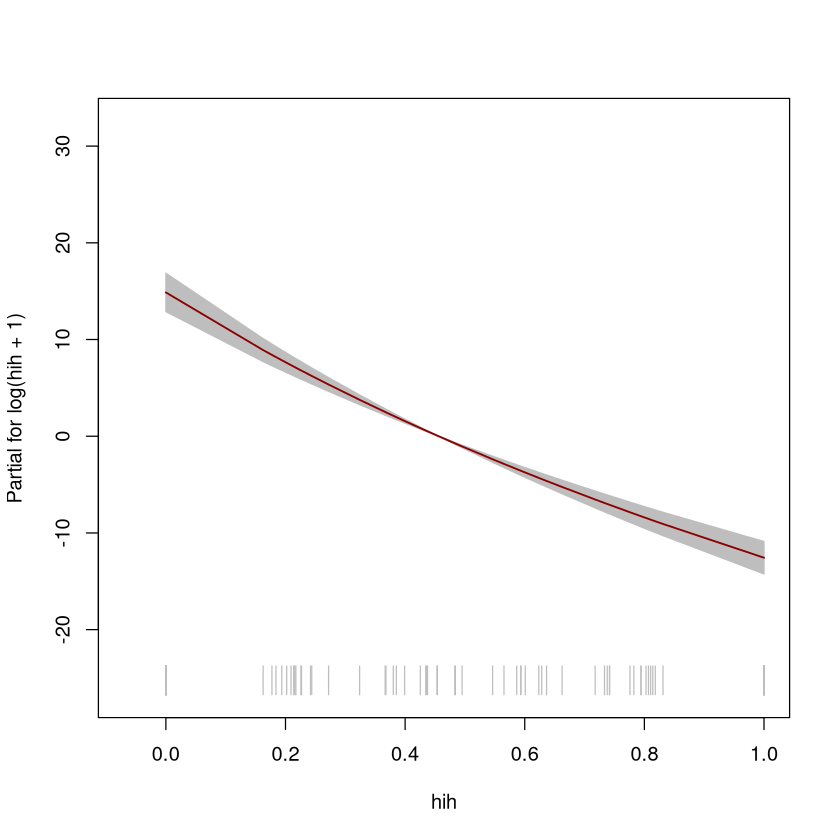

In [16]:
term.plot(lm2,what='mu',rug=TRUE)

******************************************************************
	      Summary of the Quantile Residuals
                           mean   =  -0.008427342 
                       variance   =  1.009042 
               coef. of skewness  =  0.03025772 
               coef. of kurtosis  =  2.366212 
Filliben correlation coefficient  =  0.9945676 
******************************************************************


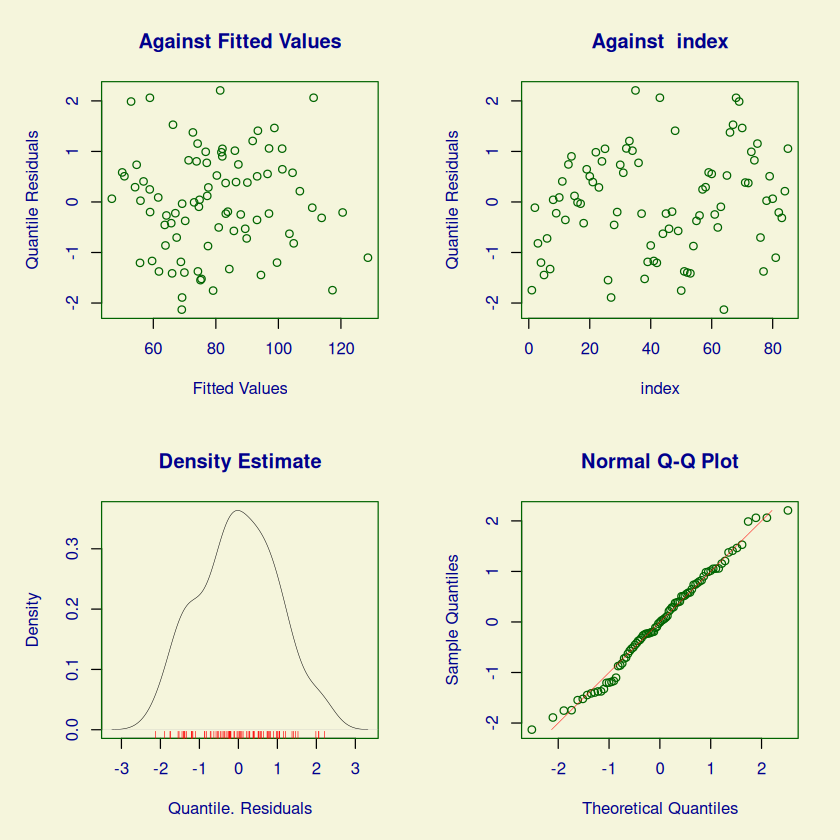

In [17]:
plot(lm2)

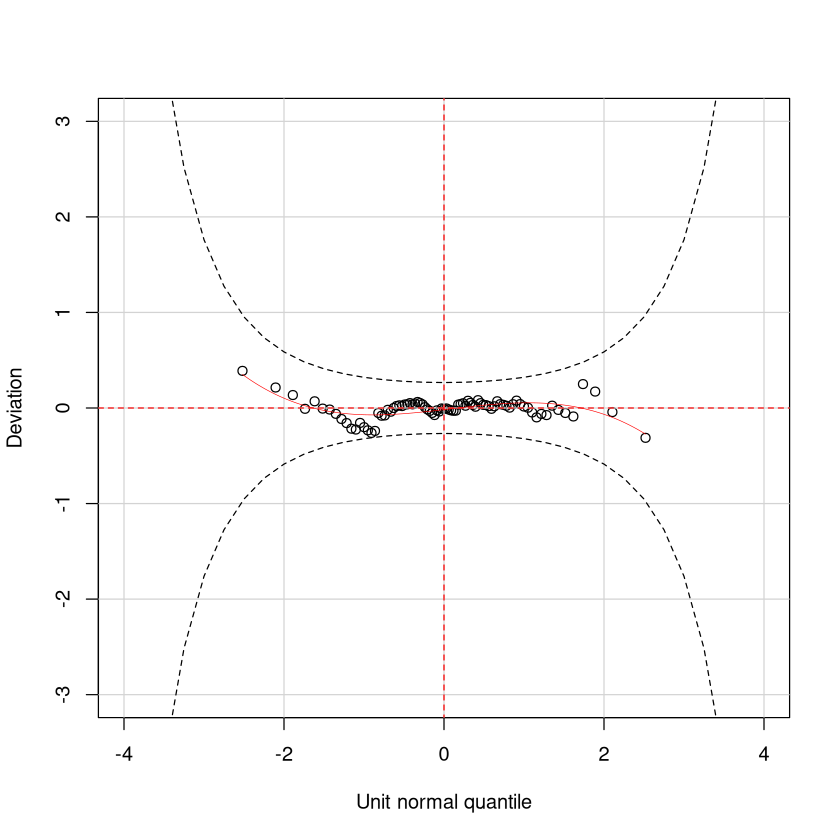

In [18]:
wp(lm2,ylim.all =3,pch=1)

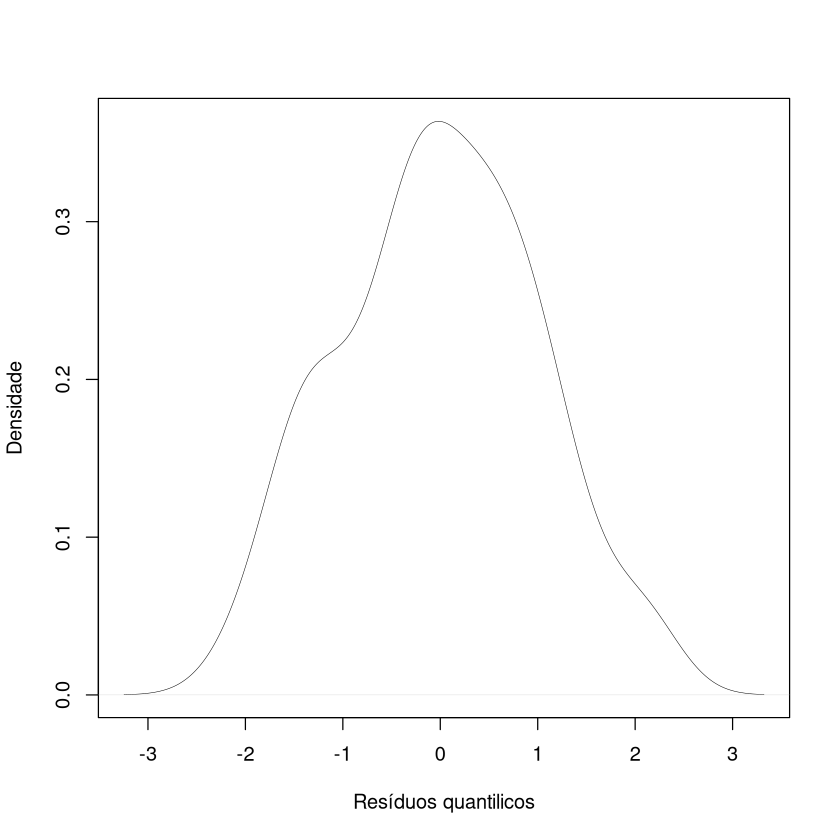

In [19]:
plot(density(resid(lm2)), 
     xlab = "Resíduos quantilicos", 
     ylab = "Densidade", 
     frame.plot = TRUE, 
     col="black", 
     lwd=0.4 ,
     main="")

In [20]:
test$di_pred <- predict(lm2,newdata=test,type="response")
rmse(test$di_pred,test$di) / mean(test$di) * 100

[1] 24.29062

In [21]:
test$resid <- test$di - test$di_pred

In [23]:
f_gamlss <- function(d, hi, h, model) {

  mu_coef <- coef(model, what = "mu") # extrair coeficients
  log_hih <- log((hi / h) + 1) # calcular logaritmo de altura relativa
  
  
  mu <- mu_coef[1] + mu_coef[2] * d + mu_coef[3] * h + mu_coef[4] * log_hih # equacao
  di_pred <- mu
  
  return(di_pred)
}

v_gamlss <- function(d, hi,h, model) {
  integrate(f = function(hi) {
  # Calcula o diametro e area transversal e integradesde .1 ate o valor especificado por hi
    di <- f_gamlss(d, hi, h, model)

    (pi / 40000) * di^2
  }, lower = 0.1, upper = hi)$value
}
